In [2]:
%load_ext autoreload
%autoreload 2

import os  
import data_strings
# Set the environment for R
if os.environ.get('HOME') == '/home/tom':
    os.environ['R_HOME'] = '/home/tom/miniconda3/envs/octagon_analysis/lib/R'  # Lab desktop
elif os.environ.get('HOME') == 1:
    os.environ['R_HOME']= r'C:\Users\tomha\miniconda3\envs\octagon_analysis\lib\R'  # Laptop
elif data_strings.DATA_FOLDER == r'D:\Users\Tom\OneDrive\PhD\SWC\data\pseudonymised_json_files':
    os.environ['R_HOME']=r'D:\Users\Tom\miniconda3\envs\octagon_analysis\lib\R'       # Home desktop
# elif:
    # append other machines here


import rpy2.robjects as robjects
print(robjects.r('R.version.string'))
import numpy as np
import matplotlib.pyplot as plt
import populate_dataframes
from pymer4.models import Lmer
import re
import seaborn as sns

import data_strings






The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[1] "R version 4.1.3 (2022-03-10)"



## Compute distance-binned heatmap bincounts for ground truth and predicted data
- Define the GLM model you want to use
- Define which data you want to use (Solo, SoloSocial, Social)
- Define which regressors and regressor values you want to filter for
- Print heatmaps

### load data

In [3]:
import pickle

analysis_dir = os.path.join('..', 'data')
# analysis_file = 'analysis_results_2levelsFirstSeenWall_normalisedWallSep.pkl'
analysis_file = 'analysis_results_3levelsFirstSeenWall_normalisedWallSep.pkl'
filename = os.path.join(analysis_dir, analysis_file)
# load the analysis results
with open(filename, 'rb') as f:
    analysis_results = pickle.load(f)

### populate dataframes for glm input

In [4]:
# populate dataframes for solo, solosocial, and social analysis_type
glm_df_solo = populate_dataframes.populate_dataframe(analysis_results, analysis_type='solo')
glm_df_solosocial = populate_dataframes.populate_dataframe(analysis_results, analysis_type='solosocial')
glm_df_social = populate_dataframes.populate_dataframe(analysis_results, analysis_type='social')


### define models

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseHigh~1+D2H+D2L+(1|GlmPlayerID)

Family: binomial	 Inference: parametric

Number of observations: 8446	 Groups: {'GlmPlayerID': 80.0}

Log-likelihood: -3761.378 	 AIC: 7530.756

Random effects:

                    Name    Var    Std
GlmPlayerID  (Intercept)  0.207  0.455

No random effect correlations specified

Fixed effects:



d:\Users\Tom\miniconda3\envs\octagon_analysis\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Text(0.5, 1.0, 'Social: ChooseHigh ~ 1 + D2H + D2L + (1|GlmPlayerID)')

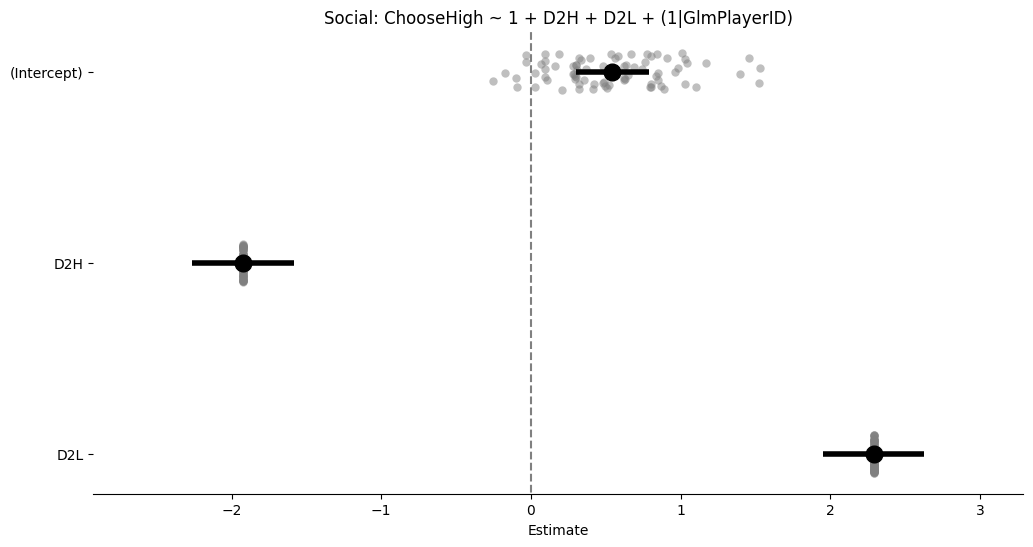

In [12]:
# SOLOS
model_formula = 'ChooseHigh ~ 1 + D2H + D2L + (1|GlmPlayerID)'
# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + FirstSeenWall + (1|GlmPlayerID)'
# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + D2H:FirstSeenWall + D2L:FirstSeenWall + (1|GlmPlayerID)'
# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + WallSep:FirstSeenWall + D2L:FirstSeenWall + D2H:FirstSeenWall + (1|GlmPlayerID)'

# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + OpponentD2H + OpponentD2L + OpponentFirstSeenWall +  (1|GlmPlayerID)'



# fit the model
# model = Lmer(model_formula, data=glm_df_solo, family='binomial')
model = Lmer(model_formula, data=glm_df_social, family='binomial')

results=model.fit(
    # explicitly specify the optimiser to avoid convergence issues
    control="optimizer='bobyqa', optCtrl=list(maxfun=10000)"
)

# display model results
# print(results)
ax = model.plot_summary()
# ax.set_title("Solo: " + model_formula)
ax.set_title("Social: " + model_formula)


### Compute spatially-binned heatmaps for model predictions and ground truth data

In [13]:
def compute_binned_heatmaps(
    df, model, regressor_names_list, regressor_values_list, 
    bin_var1, bin_var2, bin_edges, min_count=50,
    ):
    """
    Compute bins for heatmaps, both mean predictions and mean ground truth. Do this for
    each subplot defined in regressor_names_list and regressor_values_list.
    NB: [1,4] is D2L 1, D2H 4, so the first index is the y axis (D2L) and the second is the x axis (D2H).
    
    Args:
    -----------
    df: full input data for the trained model.
    model: trained GLMM.
    regressor_names_list: list of lists of names of regressors used to filter each
    subplot (e.g. ['FirstSeenWall', 'WallSep']). If any nested list
    contains a single value None, no filter will be applied for this subplot.
    regressor_values_list: list of lists of regressor values to filter for in each subplot. These must
    agree with the regressor value types. Take care that FirstSeenWall is '1.0', '2.0', etc.
    (e.g. [[1, 2], [1, 2]]). To apply more than one value in the filter, use a list instead of a value 
    bin_var1, bin_var2: variables to bin (e.g. 'D2H', 'D2L').
    bin_edges: array-like, bin edges for both variables.
    min_count: minimum count per bin to include.
    Returns: lists of binned predictions and ground truth arrays for each subplot.
    """

    # clear warnings of empty slices in calculating the mean
    # it is already expected behaviour that some bins will be empty under some conditions
    import warnings
    warnings.filterwarnings('ignore', category=RuntimeWarning)

    # list of 2D choice probability arrays for each subplot/data filter
    binned_predictions = []
    binned_groundtruth = []
    subplot = 0

    # loop through each subplot regressor filter, and each individual regressor within this
    # to create a mask for the data
    for reg_names, reg_vals in zip(regressor_names_list, regressor_values_list):
        subplot += 1
        print(f"Subplot {subplot} of {len(regressor_names_list)}: " +
              f"filtering data for {reg_names} with values {reg_vals}")
        mask = np.ones(len(df), dtype=bool)
        for name, val in zip(reg_names, reg_vals):
            if name == None:
                print(f"No mask applied for subplot {subplot}")
                continue # no mask
            elif isinstance(val, (list, tuple, set, np.ndarray)):
                # if val is an interable of values, allow any of them in the mask
                mask &= (df[name].isin(val))
            else:
                # if a single value, only allow that value in the mask
                mask &= (df[name] == val)
        df_masked = df.copy()[mask] # apply the mask to the dataframe
        print(f"length of df_masked after filtering: {len(df_masked)}, length of df: {len(df)}")

        # drop rows with nans in any columns that contain them (and are also in the model formula)
        nan_containing_cols = list(df.isna().sum()[df.isna().sum() > 0].index)
        for column in nan_containing_cols:
            pattern = re.compile(column)
            match = re.search(pattern, model.formula)
            if match:
                print(f"Dropping {df_masked[column].isna().sum()} nans in column {column}")
                df_masked.dropna(subset=column, inplace=True)
            else:
                continue
        print(f"New length of df_masked after dropping nans: {len(df_masked)}")

        # return nans for prediction/ground truth if no data
        if df_masked.empty:
            binned_predictions.append(np.full((len(bin_edges) - 1, len(bin_edges) - 1), np.nan))
            binned_groundtruth.append(np.full((len(bin_edges) - 1, len(bin_edges) - 1), np.nan))
            continue
        
        # remove nan values from input data (cannot run predictions if there are any nans in the data)
        ### I should be careful about dropping nans, and when to do it. If I'm just looking at a model without
        # firstseenwall, it will have been trained on ALL rows. If the model includes firstseenwall, it will have been trained on a subset of the data.
        # df_masked = df_masked.dropna(subset='FirstSeenWall')
        predictions = np.array(model.predict(df_masked, verify_predictions=False, skip_data_checks=True))

        # bin ground truth distances 
        binned_D2H = np.digitize(df_masked[bin_var1], bin_edges) - 1
        binned_D2L = np.digitize(df_masked[bin_var2], bin_edges) - 1

        # create 2D np array of binned prediction + ground truth means
        arr_groundtruth = np.full((len(bin_edges) -1, len(bin_edges) - 1), np.nan)
        arr_predictions = np.full((len(bin_edges) -1, len(bin_edges) - 1), np.nan)
        arr_binsizes = np.full((len(bin_edges) -1, len(bin_edges) - 1), np.nan)
        
        # loop through bins and populate the 2D arrays
        for i in range(len(bin_edges) - 1):
            for j in range(len(bin_edges) - 1):
                # create mask for predictions
                mask = (binned_D2L == i) & (binned_D2H == j)
                # print(f"n for bins ({i},{j}): {np.sum(mask)}") # print each bincount explicitly

                # calculate mean of predictions/gt for each bin
                mean_groundtruth = np.nanmean(df_masked['ChooseHigh'].values[mask])
                mean_prediction = np.nanmean(predictions[mask])

                # exclude bins with low counts
                if np.sum(mask) < min_count:
                    mean_prediction = np.nan
                    mean_groundtruth = np.nan

                # add to the 2D arrays
                arr_groundtruth[i,j] = mean_groundtruth
                arr_predictions[i,j] = mean_prediction
                arr_binsizes[i,j] = np.nansum(mask)
            
        # append subplot data to the list
        binned_predictions.append(arr_predictions)
        binned_groundtruth.append(arr_groundtruth)

        # print the binsizes for this subplot
        print(f"Binsizes for subplot {subplot}:")
        print(arr_binsizes)

    return binned_predictions, binned_groundtruth


### Heatmap of P(ChooseHigh) as a function of D2H and D2L

In [14]:
def heatmap_subplots(binned_counts, layout, cmap='viridis', vmin=0, vmax=1, cbar=True, title=None):

    fig, axs = plt.subplots(layout[0], layout[1], figsize=(layout[1]*5, layout[0]*5), squeeze=False)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(layout[0]):
        for j in range(layout[1]):
            if i*layout[1] + j >= len(binned_counts):
                break
            ax = axs[i,j]
            # cbar = True if j == layout[1] - 1 else False
            ax = sns.heatmap(binned_counts[i*layout[1] + j], ax=ax, vmin=vmin,
                              vmax=vmax, annot=True, fmt='.2f', cmap=cmap, cbar=cbar)
            ax.set_xlabel('Distance to High')
            ax.set_ylabel('Distance to Low')
            # ax.set_title('Binned Ground Truth')
            ax.invert_yaxis()
    
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return fig, axs

In [15]:
### Bin ground truth and predictions by the given variables, and display as heatmaps

Subplot 1 of 6: filtering data for ['FirstSeenWall', 'WallSep'] with values ['1.0', 0.25]
length of df_masked after filtering: 771, length of df: 5544
New length of df_masked after dropping nans: 771
Binsizes for subplot 1:
[[  6.  42.  19.   0.   0.]
 [ 28.  85.  69.  36.   0.]
 [  1.  41. 246.  69.   0.]
 [  0.   1.  32.  53.  20.]
 [  0.   0.   0.  10.  13.]]
Subplot 2 of 6: filtering data for ['FirstSeenWall', 'WallSep'] with values ['1.0', 0.5]
length of df_masked after filtering: 575, length of df: 5544
New length of df_masked after dropping nans: 575
Binsizes for subplot 2:
[[  0.   0.  21.  23.   0.]
 [  0.  43.  80.  21.  12.]
 [ 10.  69. 169.  28.   6.]
 [  8.  14.  22.  18.  15.]
 [  0.   2.   4.   9.   1.]]
Subplot 3 of 6: filtering data for ['FirstSeenWall', 'WallSep'] with values ['1.0', 1]
length of df_masked after filtering: 616, length of df: 5544
New length of df_masked after dropping nans: 616
Binsizes for subplot 3:
[[  0.   0.   0.   5.  51.]
 [  0.   0.  61.  73. 

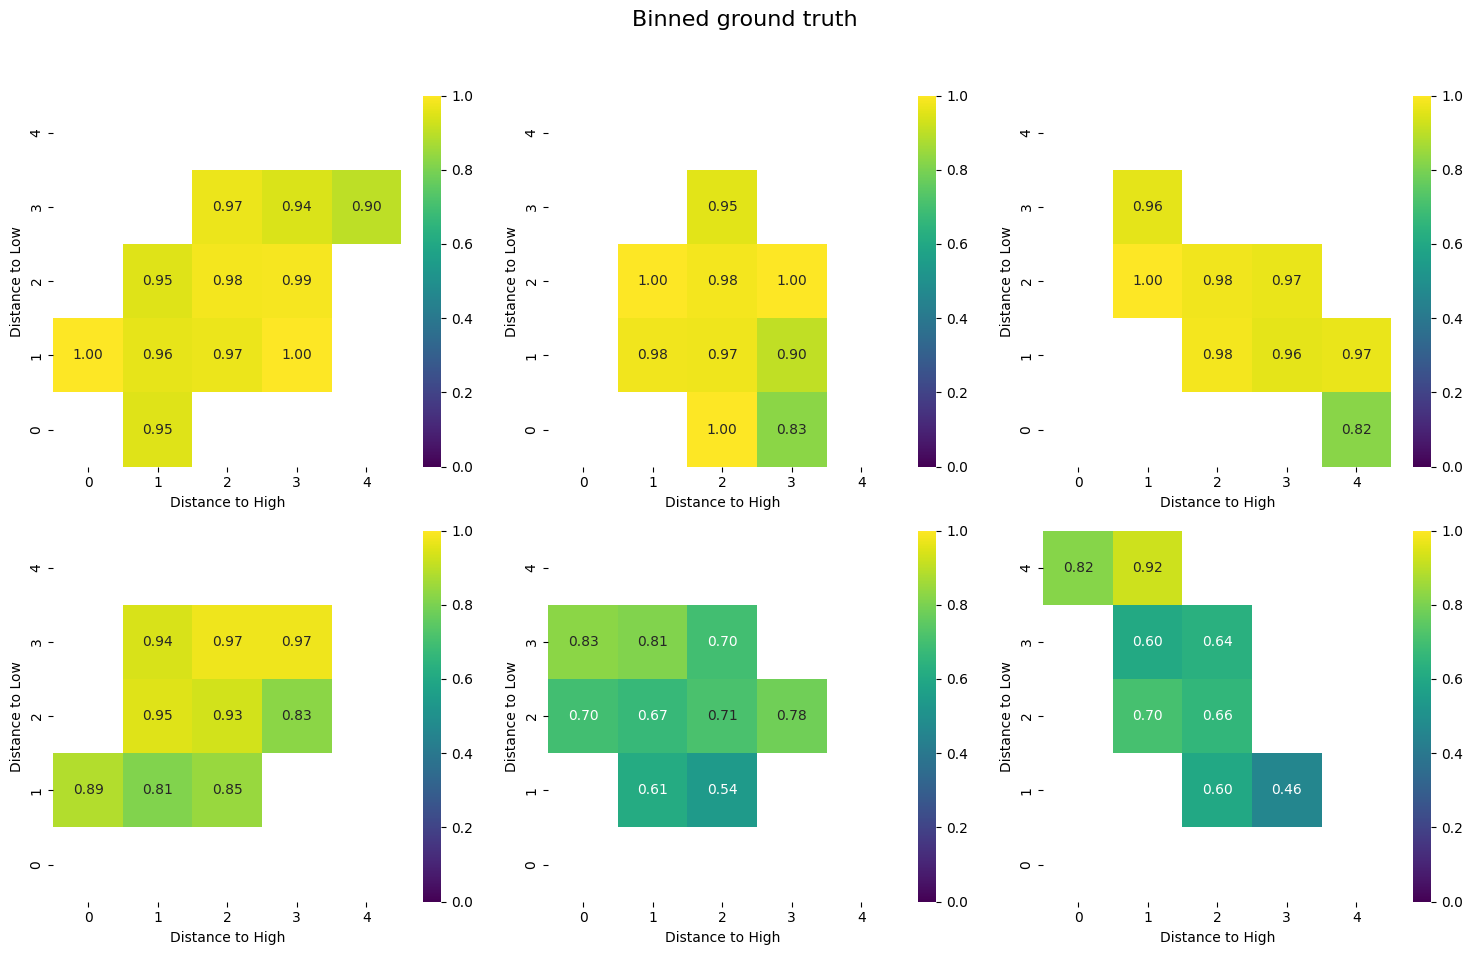

(<Figure size 1500x1000 with 12 Axes>,
 array([[<Axes: xlabel='Distance to High', ylabel='Distance to Low'>,
         <Axes: xlabel='Distance to High', ylabel='Distance to Low'>,
         <Axes: xlabel='Distance to High', ylabel='Distance to Low'>],
        [<Axes: xlabel='Distance to High', ylabel='Distance to Low'>,
         <Axes: xlabel='Distance to High', ylabel='Distance to Low'>,
         <Axes: xlabel='Distance to High', ylabel='Distance to Low'>]],
       dtype=object))

In [19]:
# These lists will be shaped into 'format': (n,m), filling by row first, s.t. the first n elements make row 0
regressor_names_list, regressor_values_list = [['FirstSeenWall','WallSep']]*6, [['1.0',0.25], ['1.0',0.5], ['1.0',1],
                                                                                ['2.0',0.25], ['2.0',0.5], ['2.0',1]]
format = (2,3) # n rows, m columns
bin_edges =  np.linspace(0,1,6) # 5 bins
min_count = 20 # minimum count per bin to include in the heatmap

# # compute heatmap bin counts
# binned_predictions, binned_groundtruth = compute_binned_heatmaps(
#     glm_df_solo, model, regressor_names_list, regressor_values_list, 
#     'D2H', 'D2L', bin_edges, min_count)
# compute heatmap bin counts
binned_predictions, binned_groundtruth = compute_binned_heatmaps(
    glm_df_solo, model, regressor_names_list, regressor_values_list, 
    'D2H', 'D2L', bin_edges, min_count)

# plot heatmaps
# heatmap_subplots(binned_predictions, (2,3), cmap='viridis', cbar=True, title='Binned predictions, full (solo) fixed model')
heatmap_subplots(binned_groundtruth, (2,3), cmap='viridis', cbar=True, title='Binned ground truth')

In [33]:
model.formula

'ChooseHigh~1+D2H+D2L+FirstSeenWall+WallSep+FirstSeenWall+OpponentFirstSeenWall+OpponentD2H+OpponentD2L+(1|GlmPlayerID)'